In [1]:
import os
import xarray as xr
import numpy as np
import xcdat as xc
# import xskillscore as xscore
import matplotlib.pyplot as plt

# import warnings
# warnings.simplefilter("ignore") # Bad Practice but lets suppress xarray warnings for now. 

from tqdm import tqdm

In [2]:
def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "", save_path: str = "", ERA: str = "CMIP6") -> np.array:
    """Calculate the rolling gradient of a DataArray

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 12*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    if not save: 
        # load and return
        return xr.open_dataarray(f"{save_path}/rolling_gradient_{name}_{ERA}.nc")

    data = data.transpose('time', 'lat', 'lon')
    grads = np.full((int((len(data.time) - window) / step), data.lat.size, data.lon.size), np.nan)
    time_idx = xr.DataArray(np.arange(window, dtype="float"), dims="time")

    data = data.chunk({"time": -1})
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        grads[j,:,:] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=False).values
        

    # Convert to xarray
    da =  xr.DataArray(grads*window, dims=("time", "lat", "lon"), coords={"lat": data.lat, "lon": data.lon, "time": np.arange(grads.shape[0])})
    
    if save:
        da.to_netcdf(f"{save_path}/rolling_gradient_{name}_{ERA}.nc")
    
    return da


Calculate 30-year rolling trends for each variable. Save output to "/home/espinosa10/tropical_pacific_clouds/cloud_masking/[CMIP]/[MODEL]_rolling_grads"

  0%|          | 0/71 [00:00<?, ?it/s]

ACCESS1-0 rolling gradients already calculated
ACCESS1-3 rolling gradients already calculated
BNU-ESM rolling gradients already calculated
CESM1-BGC rolling gradients already calculated
CESM1-WACCM rolling gradients already calculated
CNRM-CM5-2 rolling gradients already calculated
CNRM-CM5 rolling gradients already calculated
CanESM2 rolling gradients already calculated
FGOALS-s2 rolling gradients already calculated
GFDL-CM3 rolling gradients already calculated
GFDL-ESM2G rolling gradients already calculated
GFDL-ESM2M rolling gradients already calculated
GISS-E2-H-CC rolling gradients already calculated
GISS-E2-H rolling gradients already calculated
GISS-E2-R-CC rolling gradients already calculated
GISS-E2-R rolling gradients already calculated
HadGEM2-CC rolling gradients already calculated
IPSL-CM5A-LR rolling gradients already calculated
IPSL-CM5A-MR rolling gradients already calculated
IPSL-CM5B-LR rolling gradients already calculated
MIROC-ESM-CHEM rolling gradients already calc

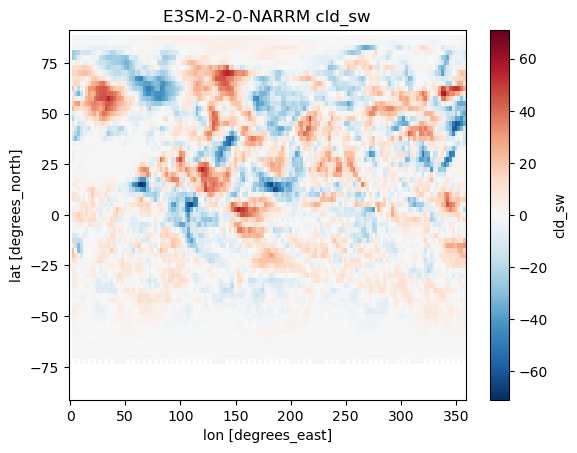

100%|██████████| 71/71 [09:32<00:00,  8.06s/it]

E3SM-2-0 rolling gradients already calculated
EC-Earth3-CC rolling gradients already calculated
EC-Earth3-LR rolling gradients already calculated
EC-Earth3-Veg-LR rolling gradients already calculated
EC-Earth3-Veg rolling gradients already calculated
EC-Earth3 rolling gradients already calculated
FGOALS-f3-L rolling gradients already calculated
FGOALS-g3 rolling gradients already calculated
GFDL-CM4 rolling gradients already calculated
GFDL-ESM4 rolling gradients already calculated
GISS-E2-1-G rolling gradients already calculated
GISS-E2-1-H rolling gradients already calculated
GISS-E2-2-H rolling gradients already calculated
HadGEM3-GC31-LL rolling gradients already calculated
HadGEM3-GC31-MM rolling gradients already calculated
IITM-ESM rolling gradients already calculated
INM-CM4-8 rolling gradients already calculated
INM-CM5-0 rolling gradients already calculated
KACE-1-0-G rolling gradients already calculated
MIROC6 rolling gradients already calculated
MPI-ESM-1-2-HAM rolling grad

In [3]:
feedbacks = ['alb', 'HS_PL', 'HS_LR', 'HS_RH', 'cld_sw', 'cld_lw', 'resid_net']
# Get all sfc_fbk files
root_dir = "/home/espinosa10/tropical_pacific_clouds/cloud_masking"
cmip6_files = [os.path.join(root_dir, "cmip6",file) for file in os.listdir(os.path.join(root_dir, "cmip6")) if file.startswith("sfc_fbks")]
cmip5_files = [os.path.join(root_dir, "cmip5",file) for file in os.listdir(os.path.join(root_dir, "cmip5")) if file.startswith("sfc_fbks")]
cmip_files = sorted(cmip6_files + cmip5_files)
# Calculate rolling 30-year gradients
for cmip_file in tqdm(cmip_files):
    model = cmip_file.split('/')[-1].split('_')[2].split('.')[0]
    era = cmip_file.split('/')[-2]
    save_path = os.path.join(root_dir, era,f"{model}_rolling_grads") 
    
    if not os.path.exists(save_path):
        print(f"calculating {model} rolling gradients")
        os.makedirs(save_path)
        sfc_fbks = xr.open_dataset(cmip_file)
        sfc_fbks.isel(time=6)["cld_sw"].plot()
        plt.title(f"{model} cld_sw")
        plt.show()
        for fb in feedbacks:
            da = calculate_rolling_gradient(sfc_fbks[fb], window=12*30, step=12, save=True, name=fb, save_path=save_path, ERA=f"sfc-fbk_{model}.r1i1p1f1")
    else: 
        print(f"{model} rolling gradients already calculated")

Using rolling 30-year trends calculated above, compute the SST tendencies due to each component.

In [2]:
fluxes = [
        "rlds", # surface downwelling longwave flux, all sky
        "rldscs", # surface downwelling longwave flux, clear sky
        "rsds", # surface downwelling shortwave flux, all sky
        "rsdscs", # surface downwelling shortwave flux, clear sky
        "rlus", # surface upwelling longwave flux, all sky
        "rsus", # surface upwelling shortwave flux, all sky (probably don't need)
        "rsuscs", # surface upwelling shortwave flux, clear sky (probably don't need)
        "hfls", # surface upward latent heat flux
        "hfss", # surface upward shortwave heat flux
        "sfcWind", # surface wind speed
        "hur", # surface relative humidity
        "tos", # sea surface temperature
        "tas", # surface air temperature
        "uas", # 10m zonal wind
        "vas", # 10m meridional wind
]

def load_fluxes(ERA):
    ds = {}
    for flux in fluxes: 
        ds[flux] = xc.open_dataset(f"../data/piControl/{flux}_mon_1850-2100_{ERA}_piControl.nc")[flux]

    if ERA == "CMIP6": # TAS is K but TOS is C 
        ds["tos"] = ds["tos"] + 273.15 # convert TOS from C to K
    elif ERA == "CMIP5": # TAS and TOS are K
        pass

    # Calculate Surface Energy Budget Terms
    DT = (ds["tas"] - ds["tos"]).rename("DT") # Low Atmosphere Stability
    LH = ds["hfls"].rename("LH") # Net Upward Latent Heat Flux
    TOS = ds["tos"].rename("TOS") # Sea Surface Temperature
    RH = ds["hur"].rename("RH") # Relative Humidity
    W = ds["sfcWind"].rename("W") # Wind Speed

    LH_Bar = LH.mean("time")
    RH_Bar = RH.mean("time")
    W_Bar = W.mean("time")
    DT_Bar = DT.mean("time")

    Lv = 2.5e6 # Latent Heat of Vaporization
    Rv = 461.5 # Gas Constant for Water Vapor
    alpha = Lv/(Rv*(TOS.mean("time"))**2)
    
    AVGES = {
        "LH_Bar": LH_Bar,
        "RH_Bar": RH_Bar,
        "W_Bar": W_Bar,
        "DT_Bar": DT_Bar,
        "alpha": alpha,
    }
    
    return AVGES

In [3]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def _load_cm_seb_tendencies(ERA, template, model):
    ERA = ERA.lower()
    ALB = xr.open_dataarray(f"{ERA}/{model}_rolling_grads/rolling_gradient_alb_sfc-fbk_{model}.r1i1p1f1.nc").to_dataset(name="ALB")
    HS_PL = xr.open_dataarray(f"{ERA}/{model}_rolling_grads/rolling_gradient_HS_PL_sfc-fbk_{model}.r1i1p1f1.nc").to_dataset(name="HS_PL")
    HS_LR = xr.open_dataarray(f"{ERA}/{model}_rolling_grads/rolling_gradient_HS_LR_sfc-fbk_{model}.r1i1p1f1.nc").to_dataset(name="HS_LR")
    HS_RH = xr.open_dataarray(f"{ERA}/{model}_rolling_grads/rolling_gradient_HS_RH_sfc-fbk_{model}.r1i1p1f1.nc").to_dataset(name="HS_RH")
    CLD_SW = xr.open_dataarray(f"{ERA}/{model}_rolling_grads/rolling_gradient_cld_sw_sfc-fbk_{model}.r1i1p1f1.nc").to_dataset(name="CLD_SW")
    CLD_LW = xr.open_dataarray(f"{ERA}/{model}_rolling_grads/rolling_gradient_cld_lw_sfc-fbk_{model}.r1i1p1f1.nc").to_dataset(name="CLD_LW")
    RESID_NET = xr.open_dataarray(f"{ERA}/{model}_rolling_grads/rolling_gradient_resid_net_sfc-fbk_{model}.r1i1p1f1.nc").to_dataset(name="RESID_NET")

    # REGRID TO SEB Terms
    lat = np.array(template.lat)
    lon = np.array(template.lon)
    lat_a = xc.create_axis("lat", lat)
    lon_a = xc.create_axis("lon", lon)
    output_grid = xc.regridder.grid.create_grid(y=lat_a, x=lon_a)
    ALB = ALB.regridder.horizontal("ALB", output_grid, tool='xesmf', method='bilinear')["ALB"]
    HS_PL = HS_PL.regridder.horizontal("HS_PL", output_grid, tool='xesmf', method='bilinear')["HS_PL"]
    HS_LR = HS_LR.regridder.horizontal("HS_LR", output_grid, tool='xesmf', method='bilinear')["HS_LR"]
    HS_RH = HS_RH.regridder.horizontal("HS_RH", output_grid, tool='xesmf', method='bilinear')["HS_RH"]
    CLD_SW = CLD_SW.regridder.horizontal("CLD_SW", output_grid, tool='xesmf', method='bilinear')["CLD_SW"]
    CLD_LW = CLD_LW.regridder.horizontal("CLD_LW", output_grid, tool='xesmf', method='bilinear')["CLD_LW"]
    RESID_NET = RESID_NET.regridder.horizontal("RESID_NET", output_grid, tool='xesmf', method='bilinear')["RESID_NET"]
    
    return (
        ALB, HS_PL, HS_LR, HS_RH, CLD_SW, CLD_LW, RESID_NET
    )


def calc_seb(AVGES, ERA: str = "cmip6", model: str = "CESM2"):

    LH_Bar = AVGES["LH_Bar"].sel(model=model)
    alpha = AVGES["alpha"].sel(model=model)


    TOS_T = (xr.open_dataarray(f"../data/piControl/rolling_gradient_TOS_{ERA.upper()}.nc")/3) # LOAD for lat/lon grid
    ALB, HS_PL, HS_RH, HS_LR, CLD_SW, CLD_LW, RESID_NET = _load_cm_seb_tendencies(ERA.lower(), TOS_T, model)

    #####################################
    ###### CLOUD MASKING RADIATION ######
    #####################################
    ALB_T = ALB/(alpha*LH_Bar)/3
    HS_PL_T = HS_PL/(alpha*LH_Bar)/3
    HS_LR_T = HS_LR/(alpha*LH_Bar)/3
    HS_RH_T = HS_RH/(alpha*LH_Bar)/3
    CLD_SW_T = CLD_SW/(alpha*LH_Bar)/3
    CLD_LW_T = CLD_LW/(alpha*LH_Bar)/3
    RESID_NET_T = RESID_NET/(alpha*LH_Bar)/3

    SEB = xr.merge([
        #### CLOUD MASKING TERMS ####
        ALB_T.rename("ALB"),
        HS_PL_T.rename("HS_PL"),
        HS_LR_T.rename("HS_LR"),
        HS_RH_T.rename("HS_RH"),
        CLD_SW_T.rename("CLD_SW"),
        CLD_LW_T.rename("CLD_LW"),
        RESID_NET_T.rename("RESID_NET")
    ])
    # SEB = SEB.drop("plev")
    # SEB = fix_coords(SEB)
    
    return SEB

In [4]:
AVGES_CMIP6 = load_fluxes("CMIP6")
AVGES_CMIP5 = load_fluxes("CMIP5")

In [11]:
print(AVGES_CMIP5["alpha"].model)
print(AVGES_CMIP6["alpha"].model)

<xarray.DataArray 'model' (model: 40)> Size: 2kB
array(['CNRM-CM5', 'bcc-csm1-1', 'bcc-csm1-1-m', 'GFDL-ESM2G', 'GFDL-ESM2M',
       'GFDL-CM3', 'EC-EARTH', 'CESM1-WACCM', 'CESM1-CAM5', 'CESM1-FASTCHEM',
       'CESM1-BGC', 'IPSL-CM5B-LR', 'IPSL-CM5A-MR', 'IPSL-CM5A-LR',
       'HadGEM2-ES', 'HadGEM2-CC', 'ACCESS1-3', 'ACCESS1-0', 'GISS-E2-H',
       'GISS-E2-R-CC', 'GISS-E2-H-CC', 'CSIRO-Mk3-6-0', 'CanESM2', 'inmcm4',
       'CMCC-CMS', 'CMCC-CM', 'CMCC-CESM', 'MIROC5', 'NorESM1-ME', 'NorESM1-M',
       'MPI-ESM-MR', 'MPI-ESM-P', 'MPI-ESM-LR', 'MRI-CGCM3', 'BNU-ESM',
       'MIROC-ESM', 'MIROC-ESM-CHEM', 'CCSM4', 'FIO-ESM', 'CNRM-CM5-2'],
      dtype='<U14')
Coordinates:
  * model    (model) <U14 2kB 'CNRM-CM5' 'bcc-csm1-1' ... 'FIO-ESM' 'CNRM-CM5-2'
<xarray.DataArray 'model' (model: 54)> Size: 4kB
array(['E3SM-1-1', 'E3SM-1-0', 'E3SM-1-1-ECA', 'KIOST-ESM', 'CIESM',
       'BCC-ESM1', 'BCC-CSM2-MR', 'CESM2-WACCM', 'CESM2-WACCM-FV2',
       'CESM2-FV2', 'CESM2', 'FGOALS-f3-L', 'CAS-ESM

In [12]:
root_dir = "/home/espinosa10/tropical_pacific_clouds/cloud_masking"
cmip6_files = [os.path.join(root_dir, "cmip6",file) for file in os.listdir(os.path.join(root_dir, "cmip6")) if file.startswith("sfc_fbks")]
cmip5_files = [os.path.join(root_dir, "cmip5",file) for file in os.listdir(os.path.join(root_dir, "cmip5")) if file.startswith("sfc_fbks")]
cmip_files = sorted(cmip6_files + cmip5_files)

for cmip_file in tqdm(cmip_files):
    model = cmip_file.split('/')[-1].split('_')[2].split('.')[0]
    era = cmip_file.split('/')[-2]
    AVGES = AVGES_CMIP6 if (era == "cmip6") else AVGES_CMIP5

    if os.path.exists(f"{root_dir}/{era}/SEB_{model}.nc"): continue

    try:
    # if True:
        print("Calculating SEB for ", model, era)
        seb_cm = calc_seb(
            AVGES=AVGES,
            ERA=era, 
            model=model,
        )
        print("SEB: ", seb_cm)
        seb_cm.to_netcdf(f"{root_dir}/{era}/SEB_{model}.nc")
    except Exception as e:
        print(f"Error calculating SEB for {model} in {era}", e)
    
    # break
    

100%|██████████| 71/71 [00:00<00:00, 9495.12it/s]

Calculating SEB for  FGOALS-s2 cmip5
Error calculating SEB for FGOALS-s2 in cmip5 "not all values found in index 'model'. Try setting the `method` keyword argument (example: method='nearest')."
Calculating SEB for  GISS-E2-R cmip5
Error calculating SEB for GISS-E2-R in cmip5 "not all values found in index 'model'. Try setting the `method` keyword argument (example: method='nearest')."
Calculating SEB for  AWI-CM-1-1-MR cmip6
Error calculating SEB for AWI-CM-1-1-MR in cmip6 "not all values found in index 'model'. Try setting the `method` keyword argument (example: method='nearest')."
Calculating SEB for  E3SM-2-0-NARRM cmip6
Error calculating SEB for E3SM-2-0-NARRM in cmip6 "not all values found in index 'model'. Try setting the `method` keyword argument (example: method='nearest')."
Calculating SEB for  KACE-1-0-G cmip6
Error calculating SEB for KACE-1-0-G in cmip6 "not all values found in index 'model'. Try setting the `method` keyword argument (example: method='nearest')."


In [13]:
# CLD_SW = xr.open_dataset(f"cmip5/SEB_ACCESS1-0.nc")
# CLD_SW["RESID_NET"].isel(time=0).plot()

In [24]:
seb_cm

<xarray.Dataset> Size: 70MB
Dimensions:    (time: 120, lon: 144, lat: 72)
Coordinates:
  * time       (time) int64 960B 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
  * lon        (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat        (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
    model      <U14 56B 'ACCESS1-0'
Data variables:
    ALB        (time, lat, lon) float64 10MB 0.0 0.0 0.0 0.0 ... 1.928 1.811 nan
    HS_PL      (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan nan
    HS_LR      (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan nan
    HS_RH      (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan nan
    CLD_SW     (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan nan
    CLD_LW     (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan nan
    RESID_NET  (time, lat, lon) float64 10MB nan nan nan nan ... nan nan nan nan

# Visualize Results: